In [2]:
import os
from dotenv import load_dotenv
import pandas as pd
from sqlalchemy import create_engine, text
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas display options
pd.set_option("display.float_format", lambda v: f"{v:,.2f}")

# Set up Seaborn styling for better-looking plots
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

### loads .env
#### Setting up the database connection

In [21]:
load_dotenv()

pg_url = (
    f"postgresql+psycopg2://{os.getenv('PGUSER')}:{os.getenv('PGPASSWORD')}"
    f"@{os.getenv('PGHOST')}:{os.getenv('PGPORT')}/{os.getenv('PGDATABASE')}"
)

engine = create_engine(pg_url, pool_pre_ping=True)

with engine.begin() as conn:
    conn.execute(text("SET search_path TO mart, curated, public;"))

with engine.begin() as conn:
    print(conn.execute(text("SELECT now()")).scalar())

2025-10-23 09:50:16.332843-04:00


In [22]:
# Load from Step 3 - features_claim and features_provider
features_claim = pd.read_sql("SELECT * FROM mart.features_claim", con=engine)
features_provider = pd.read_sql(
    "SELECT * FROM mart.features_provider", con=engine)

In [23]:
print(features_claim.head())
print(features_provider.head())

     claimid claim_type  provider      beneid claim_start   claim_end  \
0  CLM569367         OP  PRV55455  BENE100014  2009-09-08  2009-09-08   
1   CLM76080         IP  PRV55659  BENE100014  2009-11-15  2009-11-17   
2  CLM280761         OP  PRV55832  BENE100016  2009-04-02  2009-04-02   
3  CLM174738         OP  PRV55368  BENE100021  2009-02-03  2009-02-03   
4  CLM296629         OP  PRV55209  BENE100040  2009-04-10  2009-04-10   

   reimb_amt  deductible_paid  dx_count  px_count  ... amount_high_flag  \
0     100.00             0.00         1         0  ...                0   
1   3,000.00         1,068.00         6         0  ...                0   
2      60.00             0.00         2         0  ...                0   
3      50.00             0.00         2         0  ...                0   
4     200.00             0.00         2         0  ...                0   

  exact_duplicate_flag  near_duplicate_group_size  dup_exact_flag  \
0                    0                   

##### A - Load only the columns we need (claim & provider)


In [24]:
# Claim-level slice
q_claim = """
SELECT claimid, claim_type, reimb_amt, deductible_paid, los_days, dx_count, px_count
FROM mart.features_claim
"""
claims = pd.read_sql(q_claim, con=engine)

# Provider-level slice
q_prov = """
SELECT provider, claims_30d, reimb_30d, unique_benes_30d,
       dx_distinct_30d, px_distinct_30d, avg_reimb_day_30d,
       deductible_share_30d,
       ip_avg_z_reimb_365, ip_max_z_reimb_365, ip_avg_z_los_365, ip_max_z_los_365,
       op_avg_z_reimb_365, op_max_z_reimb_365
FROM mart.features_provider
"""
providers = pd.read_sql(q_prov, con=engine)

claims.shape, providers.shape

((558211, 7), (5410, 14))

### 3.0 - Data Quality Validation & Verification

##### A - Verify feature tables exist and are populated

In [7]:
# Step 1: Verify that feature tables exist and are populated
print("="*70)
print("STEP 1: FEATURE TABLE VERIFICATION")
print("="*70)

# Check if feature tables exist
with engine.begin() as conn:
    tables_check = conn.execute(text("""
        SELECT table_name, 
               pg_size_pretty(pg_total_relation_size(quote_ident(table_schema) || '.' || quote_ident(table_name))) as size
        FROM information_schema.tables 
        WHERE table_schema = 'mart' 
        AND table_name IN ('features_provider', 'features_claim')
        ORDER BY table_name
    """)).fetchall()

    print("\nAvailable Feature Tables:")
    if tables_check:
        for table_name, size in tables_check:
            print(f"  ✓ mart.{table_name} (Size: {size})")
    else:
        print("  ✗ No feature tables found in mart schema!")

# Get row counts
with engine.begin() as conn:
    claim_count = conn.execute(
        text("SELECT COUNT(*) FROM mart.features_claim")).scalar()
    provider_count = conn.execute(
        text("SELECT COUNT(*) FROM mart.features_provider")).scalar()

    print(f"\nRow Counts:")
    print(f"  mart.features_claim: {claim_count:,} rows")
    print(f"  mart.features_provider: {provider_count:,} rows")

# Verify loaded dataframes match database counts
print(f"\nLoaded DataFrame Verification:")
print(f"claims dataframe: {len(claims):,} rows")
print(f"providers dataframe: {len(providers):,} rows")

if len(claims) == claim_count:
    print("  ✓ Claims data fully loaded")
else:
    print(
        f"  ⚠️ Warning: Claims dataframe has {len(claims)} rows but table has {claim_count} rows")

if len(providers) == provider_count:
    print("  ✓ Provider data fully loaded")
else:
    print(
        f"  ⚠️ Warning: Provider dataframe has {len(providers)} rows but table has {provider_count} rows")

print("="*70)

STEP 1: FEATURE TABLE VERIFICATION

Available Feature Tables:
  ✓ mart.features_claim (Size: 118 MB)
  ✓ mart.features_provider (Size: 1560 kB)

Row Counts:
  mart.features_claim: 558,211 rows
  mart.features_provider: 5,410 rows

Loaded DataFrame Verification:
claims dataframe: 558,211 rows
providers dataframe: 5,410 rows
  ✓ Claims data fully loaded
  ✓ Provider data fully loaded


##### B - Check for missing values and data completeness

In [8]:
# Step 2: Data Quality Checks - Missing Values and Completeness
print("\n" + "="*70)
print("STEP 2: DATA COMPLETENESS CHECKS")
print("="*70)

# Check for missing values in claims
print("\n📊 Missing Values in Claims Data:")
print("-" * 70)
missing_claims = claims.isnull().sum()
missing_pct_claims = (claims.isnull().sum() / len(claims) * 100).round(2)
missing_df_claims = pd.DataFrame({
    'Missing Count': missing_claims,
    'Missing %': missing_pct_claims
})
missing_df_claims = missing_df_claims[missing_df_claims['Missing Count'] > 0].sort_values(
    'Missing Count', ascending=False)

if len(missing_df_claims) > 0:
    print(missing_df_claims)
else:
    print("  ✓ No missing values found in claims data!")

# Check for missing values in providers
print("\n📊 Missing Values in Provider Data:")
print("-" * 70)
missing_prov = providers.isnull().sum()
missing_pct_prov = (providers.isnull().sum() / len(providers) * 100).round(2)
missing_df_prov = pd.DataFrame({
    'Missing Count': missing_prov,
    'Missing %': missing_pct_prov
})
missing_df_prov = missing_df_prov[missing_df_prov['Missing Count'] > 0].sort_values(
    'Missing Count', ascending=False)

if len(missing_df_prov) > 0:
    print(missing_df_prov)
    print("\n⚠️ Note: Z-scores can be NULL for providers with small peer groups (expected behavior)")
else:
    print("  ✓ No missing values found in provider data!")

# Check for zeros in important fields (potential data quality issues)
print("\n📊 Zero Value Checks:")
print("-" * 70)

if 'reimb_amt' in claims.columns:
    zero_reimb = (claims['reimb_amt'] == 0).sum()
    print(
        f"Claims with $0 reimbursement: {zero_reimb:,} ({zero_reimb/len(claims)*100:.2f}%)")

if 'claims_30d' in providers.columns:
    zero_claims = (providers['claims_30d'] == 0).sum()
    print(
        f"Providers with 0 claims (30d): {zero_claims:,} ({zero_claims/len(providers)*100:.2f}%)")

if 'unique_benes_30d' in providers.columns:
    zero_benes = (providers['unique_benes_30d'] == 0).sum()
    print(
        f"Providers with 0 unique beneficiaries (30d): {zero_benes:,} ({zero_benes/len(providers)*100:.2f}%)")

print("="*70)


STEP 2: DATA COMPLETENESS CHECKS

📊 Missing Values in Claims Data:
----------------------------------------------------------------------
                 Missing Count  Missing %
los_days                517737      92.75
deductible_paid            899       0.16

📊 Missing Values in Provider Data:
----------------------------------------------------------------------
                      Missing Count  Missing %
ip_avg_z_reimb_365             3322      61.40
ip_max_z_reimb_365             3322      61.40
ip_avg_z_los_365               3322      61.40
ip_max_z_los_365               3322      61.40
op_avg_z_reimb_365              404       7.47
op_max_z_reimb_365              404       7.47
deductible_share_30d             16       0.30
avg_reimb_day_30d                15       0.28

⚠️ Note: Z-scores can be NULL for providers with small peer groups (expected behavior)

📊 Zero Value Checks:
----------------------------------------------------------------------
Claims with $0 reimburse

##### C - Verify value ranges and fix division by zero issues

In [9]:
# Step 3: Value Range Verification and NULL Handling
print("\n" + "="*70)
print("STEP 3: VALUE RANGE VERIFICATION & NULL HANDLING")
print("="*70)

# Verify reimbursement amount ranges
print("\n📊 Reimbursement Amount Ranges:")
print("-" * 70)

if 'reimb_amt' in claims.columns and 'claim_type' in claims.columns:
    for claim_type in claims['claim_type'].unique():
        subset = claims[claims['claim_type'] == claim_type]['reimb_amt']
        print(f"\n{claim_type} Claims:")
        print(f"  Min: ${subset.min():,.2f}")
        print(f"  Max: ${subset.max():,.2f}")
        print(f"  Mean: ${subset.mean():,.2f}")
        print(f"  Median: ${subset.median():,.2f}")

        # Check for extreme values
        if claim_type == 'IP':
            extreme = subset[subset > 125000]
            if len(extreme) > 0:
                print(
                    f"  ⚠️ Warning: {len(extreme)} claims exceed expected max ($125,000)")
        elif claim_type == 'OP':
            extreme = subset[subset > 102500]
            if len(extreme) > 0:
                print(
                    f"  ⚠️ Warning: {len(extreme)} claims exceed expected max ($102,500)")

# Fix the avg_reimb_per_claim calculation to handle division by zero
print("\n📊 Fixing Division by Zero Issues:")
print("-" * 70)

if 'reimb_30d' in providers.columns and 'claims_30d' in providers.columns:
    # Check for zero claims before fixing
    zero_claims_count = (providers['claims_30d'] == 0).sum()

    if zero_claims_count > 0:
        print(
            f"Found {zero_claims_count} providers with 0 claims (would cause division by zero)")

    # Fix: Replace 0 with NaN to avoid division by zero
    providers['avg_reimb_per_claim'] = providers['reimb_30d'] / \
        providers['claims_30d'].replace(0, np.nan)

    # Report on the fix
    null_avg = providers['avg_reimb_per_claim'].isnull().sum()
    print(
        f"✓ Fixed: Set avg_reimb_per_claim to NaN for {null_avg} providers with 0 claims")
    print(f"Valid avg_reimb_per_claim values: {len(providers) - null_avg:,}")

# Check for negative values (data quality issue)
print("\n📊 Checking for Negative Values (Data Quality Issues):")
print("-" * 70)

negative_found = False

if 'reimb_amt' in claims.columns:
    neg_reimb = (claims['reimb_amt'] < 0).sum()
    if neg_reimb > 0:
        print(
            f"⚠️ Warning: {neg_reimb} claims with negative reimbursement amounts")
        negative_found = True

if 'los_days' in claims.columns:
    neg_los = (claims['los_days'] < 0).sum()
    if neg_los > 0:
        print(f"⚠️ Warning: {neg_los} claims with negative length of stay")
        negative_found = True

if 'reimb_30d' in providers.columns:
    neg_prov_reimb = (providers['reimb_30d'] < 0).sum()
    if neg_prov_reimb > 0:
        print(
            f"⚠️ Warning: {neg_prov_reimb} providers with negative reimbursement")
        negative_found = True

if not negative_found:
    print("✓ No negative values found in key numeric fields")

# Summary statistics for key fields
print("\n📊 Key Field Statistics Summary:")
print("-" * 70)

# Claims summary
if 'reimb_amt' in claims.columns:
    print(f"\nClaim Reimbursement:")
    print(f"  Total claims: {len(claims):,}")
    print(f"  Total reimbursed: ${claims['reimb_amt'].sum():,.2f}")
    print(f"  Average per claim: ${claims['reimb_amt'].mean():,.2f}")

# Provider summary
if 'reimb_30d' in providers.columns:
    print(f"\nProvider Activity (30-day window):")
    print(f"  Total providers: {len(providers):,}")
    print(f"  Providers with claims: {(providers['claims_30d'] > 0).sum():,}")
    print(f"  Total reimbursement: ${providers['reimb_30d'].sum():,.2f}")
    print(f"  Average per provider: ${providers['reimb_30d'].mean():,.2f}")

print("\n" + "="*70)
print("✓ DATA QUALITY VALIDATION COMPLETE")
print("="*70)


STEP 3: VALUE RANGE VERIFICATION & NULL HANDLING

📊 Reimbursement Amount Ranges:
----------------------------------------------------------------------

OP Claims:
  Min: $0.00
  Max: $102,500.00
  Mean: $286.33
  Median: $80.00

IP Claims:
  Min: $0.00
  Max: $125,000.00
  Mean: $10,087.88
  Median: $7,000.00

📊 Fixing Division by Zero Issues:
----------------------------------------------------------------------
✓ Fixed: Set avg_reimb_per_claim to NaN for 0 providers with 0 claims
Valid avg_reimb_per_claim values: 5,410

📊 Checking for Negative Values (Data Quality Issues):
----------------------------------------------------------------------
✓ No negative values found in key numeric fields

📊 Key Field Statistics Summary:
----------------------------------------------------------------------

Claim Reimbursement:
  Total claims: 558,211
  Total reimbursed: $556,543,140.00
  Average per claim: $997.01

Provider Activity (30-day window):
  Total providers: 5,410
  Providers with cla

### 3.1 - Visualize distributions of key features (histograms, box plots, quantiles)

#### Helper: Freedman–Diaconis binning (auto bins for skewed data)

In [10]:
def fd_bins(series: pd.Series):
    """Return an integer #bins using the Freedman–Diaconis rule."""
    s = series.dropna().values
    n = s.size
    if n < 2:
        return 10
    iqr = np.subtract(*np.percentile(s, [75, 25]))
    if iqr == 0:
        return 10
    # 2 * IQR / n^(1/3)
    bw = 2 * iqr / np.cbrt(n)
    bins = int(np.ptp(s) / bw) if bw > 0 else 10
    return max(10, min(bins, 200))

#### 3 - Quick quantiles (sanity) — claims

In [11]:
num_cols_claim = ["reimb_amt", "deductible_paid",
                  "los_days", "dx_count", "px_count"]
quant_claim = claims[num_cols_claim].quantile([0.25, 0.5, 0.75, 0.95, 0.99])
quant_claim

,reimb_amt,deductible_paid,los_days,dx_count,px_count
0.25,40.00,0.00,2.00,1.00,0.00
0.50,80.00,0.00,4.00,2.00,0.00
0.75,300.00,0.00,7.00,4.00,0.00
0.95,"5,000.00","1,068.00",17.00,9.00,0.00
0.99,"17,000.00","1,068.00",32.00,9.00,1.00


#### 4 - Histograms & boxplots — claim level

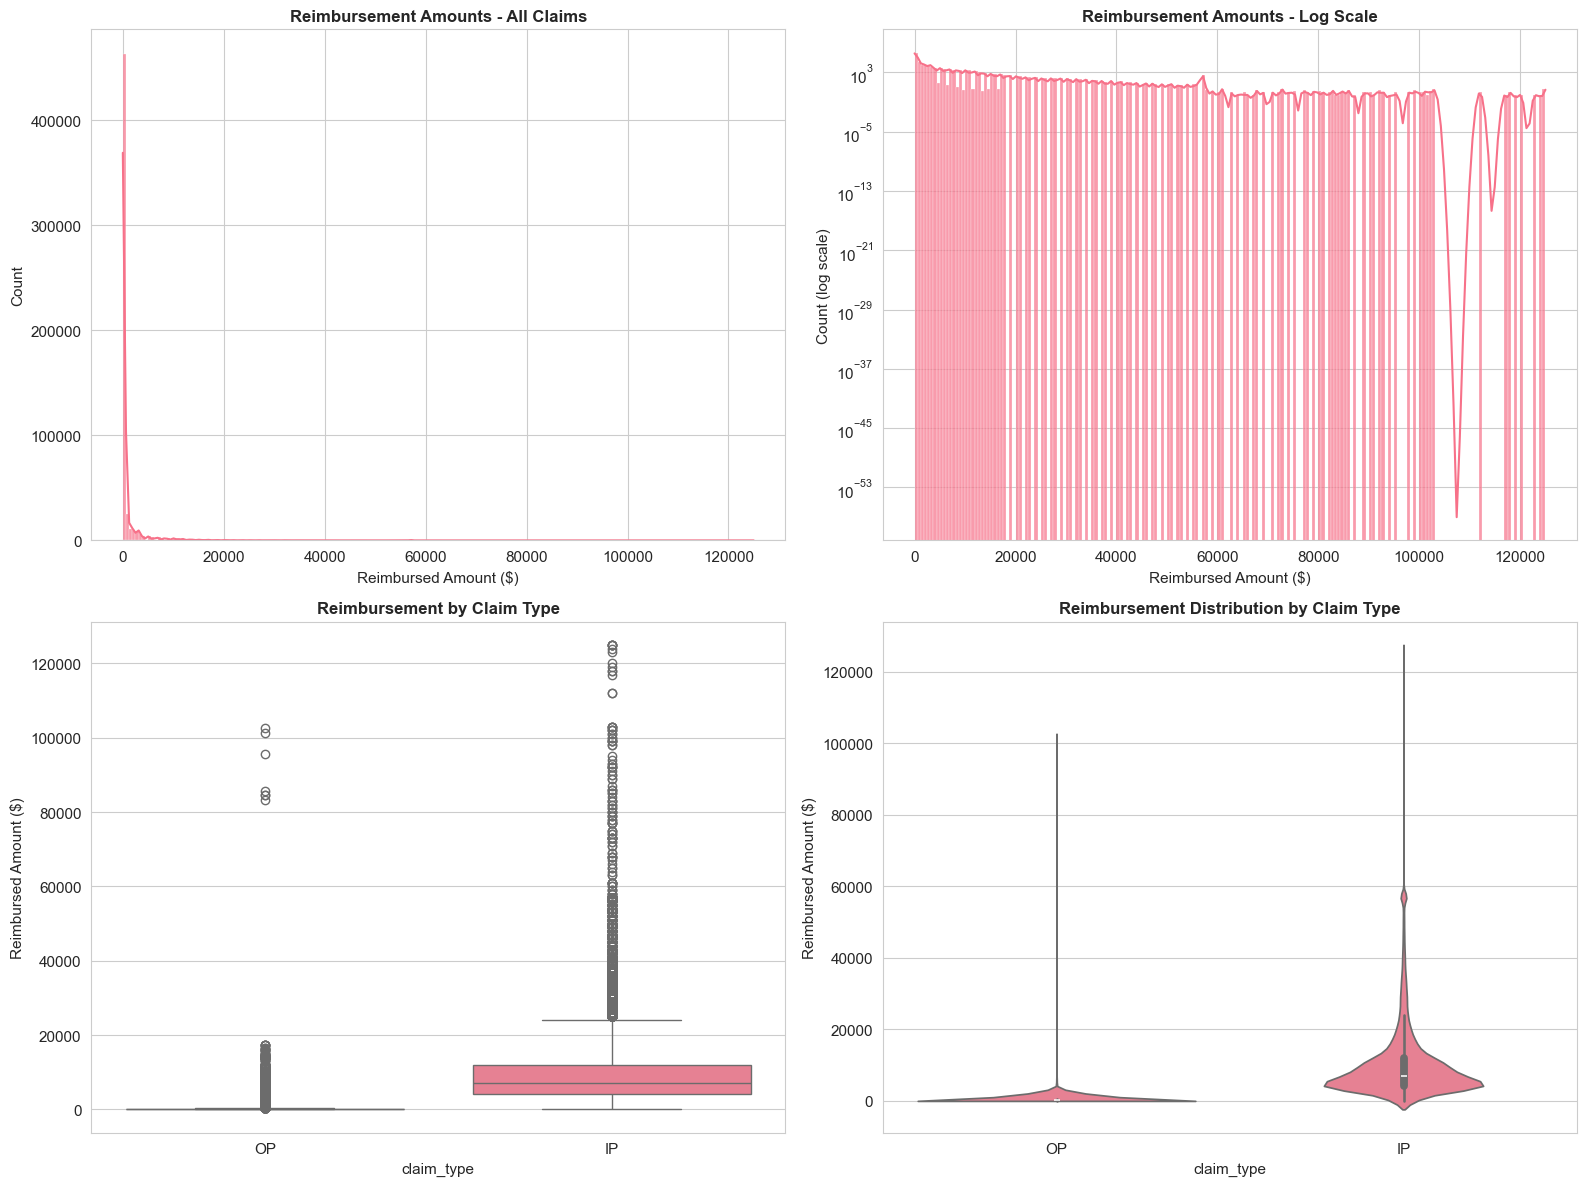

<Figure size 1400x800 with 0 Axes>

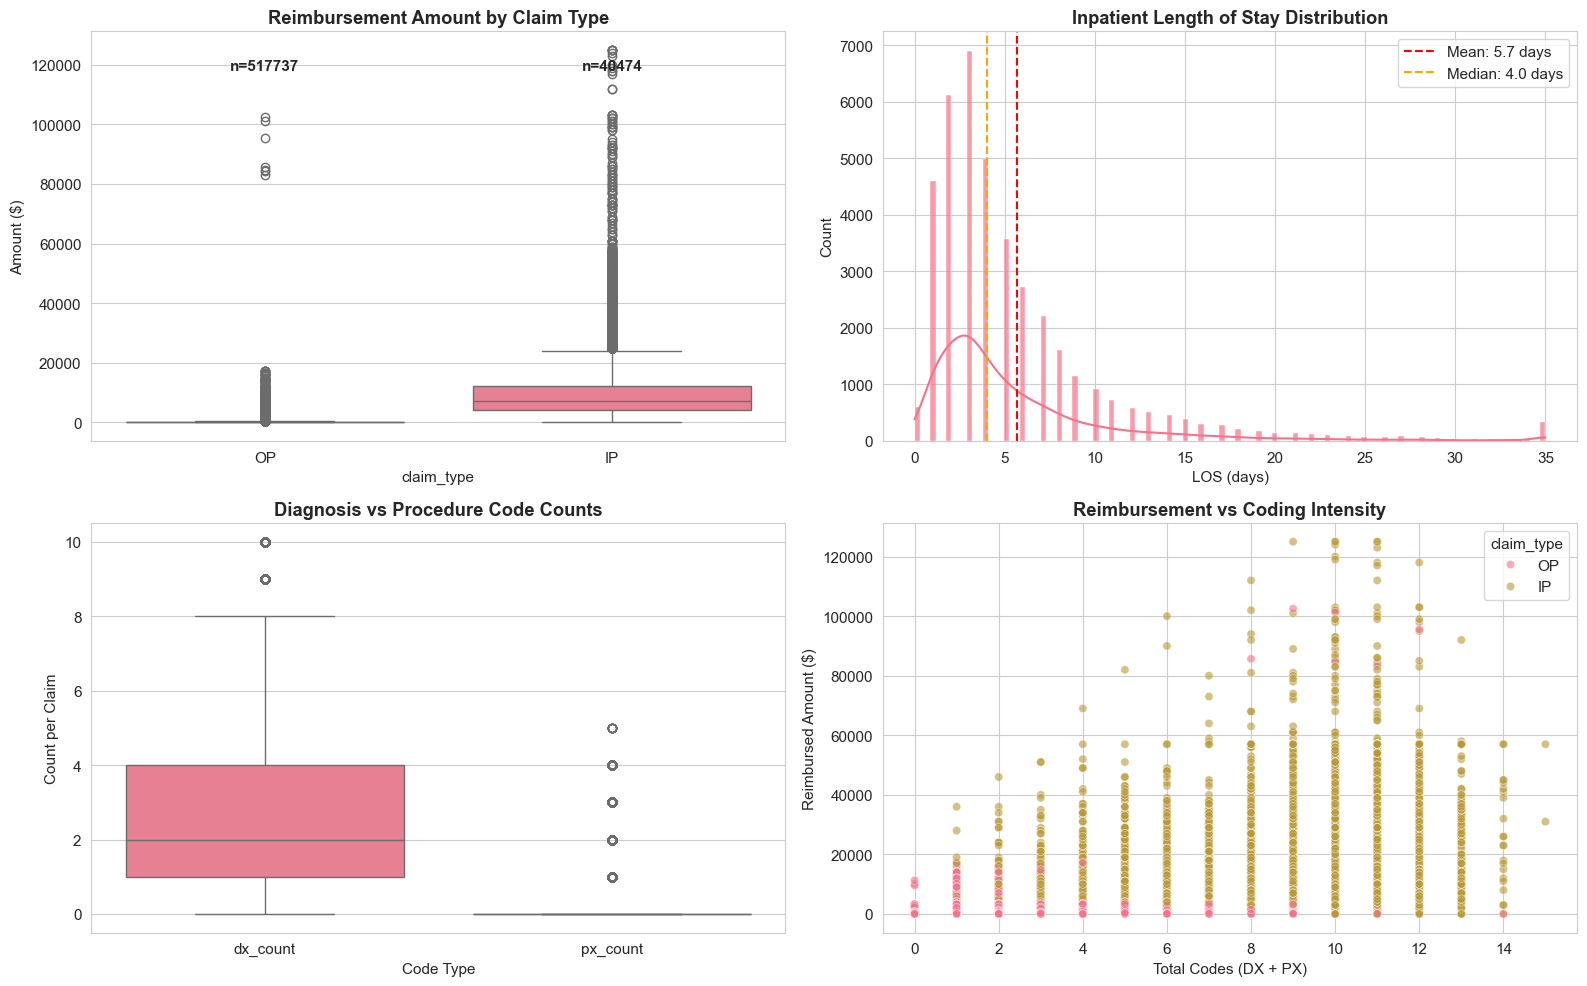


CLAIM-LEVEL SUMMARY STATISTICS
           reimb_amt                                              los_days  \
               count      mean   median       std  min        max     mean   
claim_type                                                                   
IP             40474 10,087.88 7,000.00 10,303.10 0.00 125,000.00     5.67   
OP            517737    286.33    80.00    694.03 0.00 102,500.00      NaN   

                  dx_count        px_count         
           median     mean median     mean median  
claim_type                                         
IP           4.00     8.09   9.00     0.73   1.00  
OP            NaN     2.61   2.00     0.00   0.00  


In [12]:
# Enhanced claim-level visualizations with Seaborn

# 1. Reimbursement amount analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Overall distribution with better styling
sns.histplot(data=claims, x="reimb_amt", kde=True, ax=axes[0,0], 
             bins=fd_bins(claims["reimb_amt"]), alpha=0.7)
axes[0,0].set_title("Reimbursement Amounts - All Claims", fontsize=12, fontweight='bold')
axes[0,0].set_xlabel("Reimbursed Amount ($)")
axes[0,0].set_ylabel("Count")

# Log scale view
sns.histplot(data=claims, x="reimb_amt", kde=True, ax=axes[0,1], 
             bins=fd_bins(claims["reimb_amt"]), alpha=0.7)
axes[0,1].set_yscale("log")
axes[0,1].set_title("Reimbursement Amounts - Log Scale", fontsize=12, fontweight='bold')
axes[0,1].set_xlabel("Reimbursed Amount ($)")
axes[0,1].set_ylabel("Count (log scale)")

# By claim type - enhanced boxplot
sns.boxplot(data=claims, x="claim_type", y="reimb_amt", ax=axes[1,0])
axes[1,0].set_title("Reimbursement by Claim Type", fontsize=12, fontweight='bold')
axes[1,0].set_ylabel("Reimbursed Amount ($)")

# By claim type - violin plot for distribution shape
sns.violinplot(data=claims, x="claim_type", y="reimb_amt", ax=axes[1,1])
axes[1,1].set_title("Reimbursement Distribution by Claim Type", fontsize=12, fontweight='bold')
axes[1,1].set_ylabel("Reimbursed Amount ($)")

plt.tight_layout()
plt.show()

# 2. Claim type comparison with statistical annotations
plt.figure(figsize=(14, 8))

# Create subplots for different metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Reimbursement by claim type with statistical test
sns.boxplot(data=claims, x="claim_type", y="reimb_amt", ax=axes[0,0])
axes[0,0].set_title("Reimbursement Amount by Claim Type", fontweight='bold')
axes[0,0].set_ylabel("Amount ($)")

# Add sample sizes
for i, claim_type in enumerate(claims['claim_type'].unique()):
    count = len(claims[claims['claim_type'] == claim_type])
    axes[0,0].text(i, axes[0,0].get_ylim()[1]*0.9, f'n={count}', 
                   ha='center', fontweight='bold')

# Length of stay for inpatient claims
ip_claims = claims[claims["claim_type"] == "IP"].copy()
if not ip_claims.empty:
    sns.histplot(data=ip_claims, x="los_days", kde=True, ax=axes[0,1], 
                 bins=fd_bins(ip_claims["los_days"]), alpha=0.7)
    axes[0,1].set_title("Inpatient Length of Stay Distribution", fontweight='bold')
    axes[0,1].set_xlabel("LOS (days)")
    axes[0,1].set_ylabel("Count")
    
    # Add statistics
    mean_los = ip_claims["los_days"].mean()
    median_los = ip_claims["los_days"].median()
    axes[0,1].axvline(mean_los, color='red', linestyle='--', 
                      label=f'Mean: {mean_los:.1f} days')
    axes[0,1].axvline(median_los, color='orange', linestyle='--', 
                      label=f'Median: {median_los:.1f} days')
    axes[0,1].legend()

# Diagnosis and procedure counts
claims_coding = claims[["dx_count", "px_count"]].copy()
claims_coding_melted = claims_coding.melt(var_name='Code_Type', value_name='Count')

sns.boxplot(data=claims_coding_melted, x='Code_Type', y='Count', ax=axes[1,0])
axes[1,0].set_title("Diagnosis vs Procedure Code Counts", fontweight='bold')
axes[1,0].set_xlabel("Code Type")
axes[1,0].set_ylabel("Count per Claim")

# Scatter plot: reimbursement vs coding intensity
claims_with_coding = claims.copy()
claims_with_coding['total_codes'] = claims_with_coding['dx_count'] + claims_with_coding['px_count']

sns.scatterplot(data=claims_with_coding, x='total_codes', y='reimb_amt', 
                hue='claim_type', alpha=0.6, ax=axes[1,1])
axes[1,1].set_title("Reimbursement vs Coding Intensity", fontweight='bold')
axes[1,1].set_xlabel("Total Codes (DX + PX)")
axes[1,1].set_ylabel("Reimbursed Amount ($)")

plt.tight_layout()
plt.show()

# 3. Summary statistics table with better formatting
print("\n" + "="*60)
print("CLAIM-LEVEL SUMMARY STATISTICS")
print("="*60)

summary_stats = claims.groupby('claim_type').agg({
    'reimb_amt': ['count', 'mean', 'median', 'std', 'min', 'max'],
    'los_days': ['mean', 'median'],
    'dx_count': ['mean', 'median'],
    'px_count': ['mean', 'median']
}).round(2)

print(summary_stats)

#### 5 - Quick quantiles — provider

In [13]:
num_cols_prov = [
    "claims_30d", "reimb_30d", "unique_benes_30d",
    "dx_distinct_30d", "px_distinct_30d", "avg_reimb_day_30d",
    "deductible_share_30d",
    "ip_avg_z_reimb_365", "ip_max_z_reimb_365", "ip_avg_z_los_365", "ip_max_z_los_365",
    "op_avg_z_reimb_365", "op_max_z_reimb_365"
]
quant_prov = providers[num_cols_prov].quantile([0.25, 0.5, 0.75, 0.95, 0.99])
quant_prov

,claims_30d,reimb_30d,unique_benes_30d,dx_distinct_30d,px_distinct_30d,avg_reimb_day_30d,deductible_share_30d,ip_avg_z_reimb_365,ip_max_z_reimb_365,ip_avg_z_los_365,ip_max_z_los_365,op_avg_z_reimb_365,op_max_z_reimb_365
0.25,10.00,"4,272.50",1.00,4.00,0.00,240.84,0.00,-0.25,0.39,-0.26,0.39,-0.19,0.20
0.50,30.00,"9,900.00",3.00,10.00,0.00,433.10,0.02,-0.04,1.61,-0.05,1.46,-0.05,0.58
0.75,34.00,"31,622.50",7.00,22.00,0.00,"1,708.09",0.09,0.18,3.14,0.17,2.98,0.09,1.28
0.95,48.00,"151,982.00",28.00,77.00,3.00,"9,183.53",0.15,0.83,4.60,0.73,4.87,0.57,3.42
0.99,93.91,"274,976.60",79.82,183.00,6.00,"15,553.00",0.27,1.57,5.18,1.68,6.06,1.40,4.99


#### 6 - Histograms & boxplots — provider level

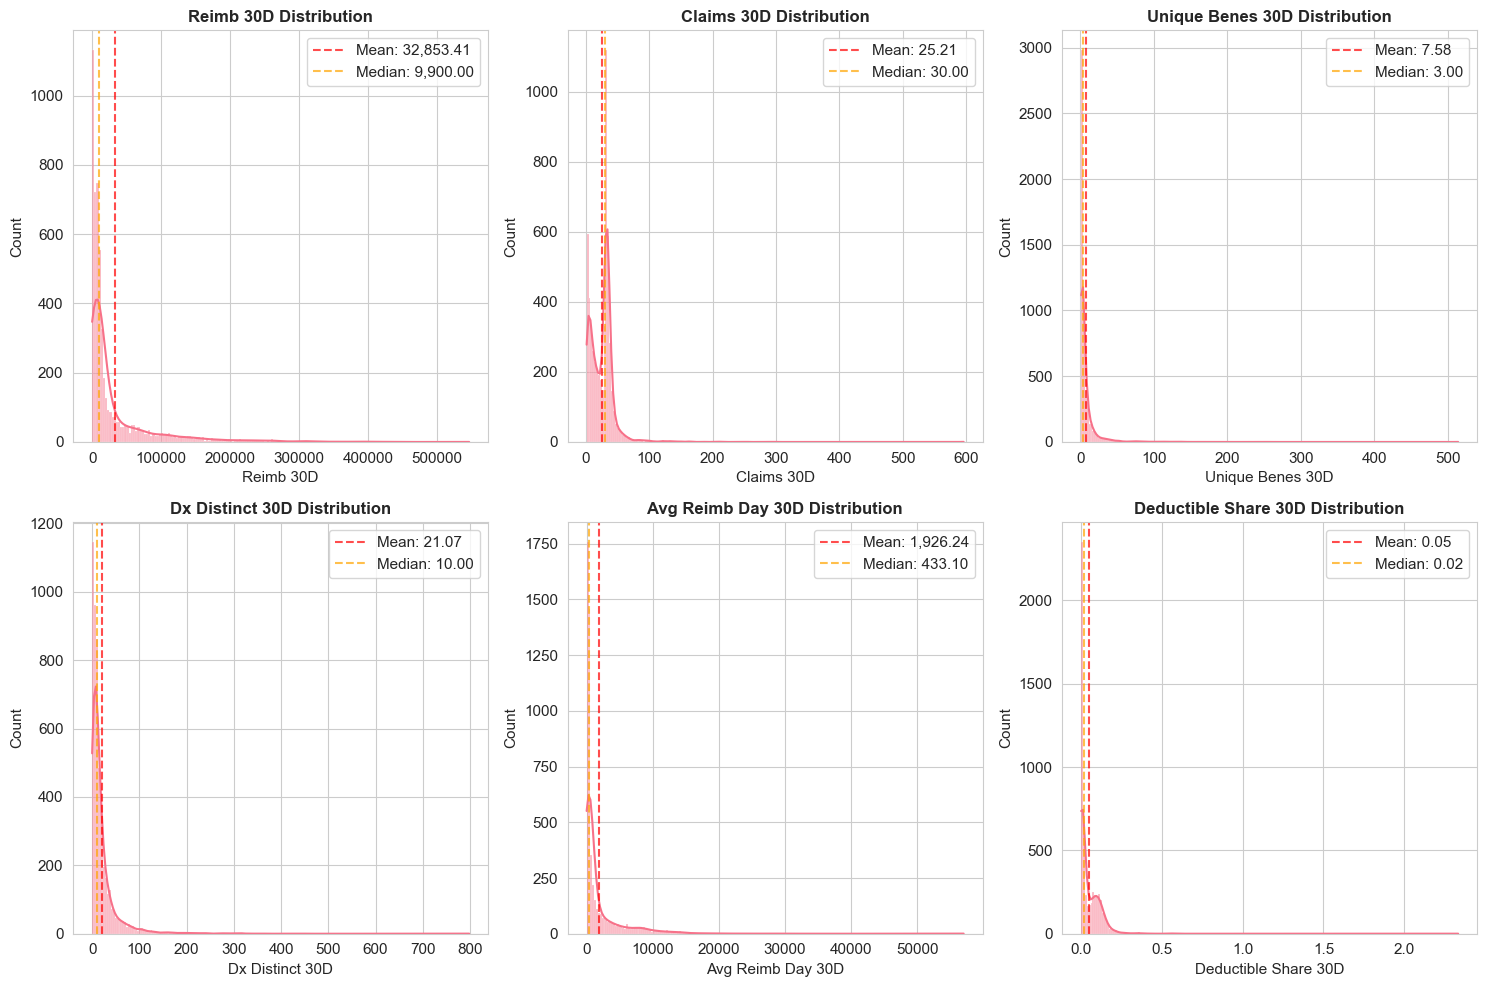

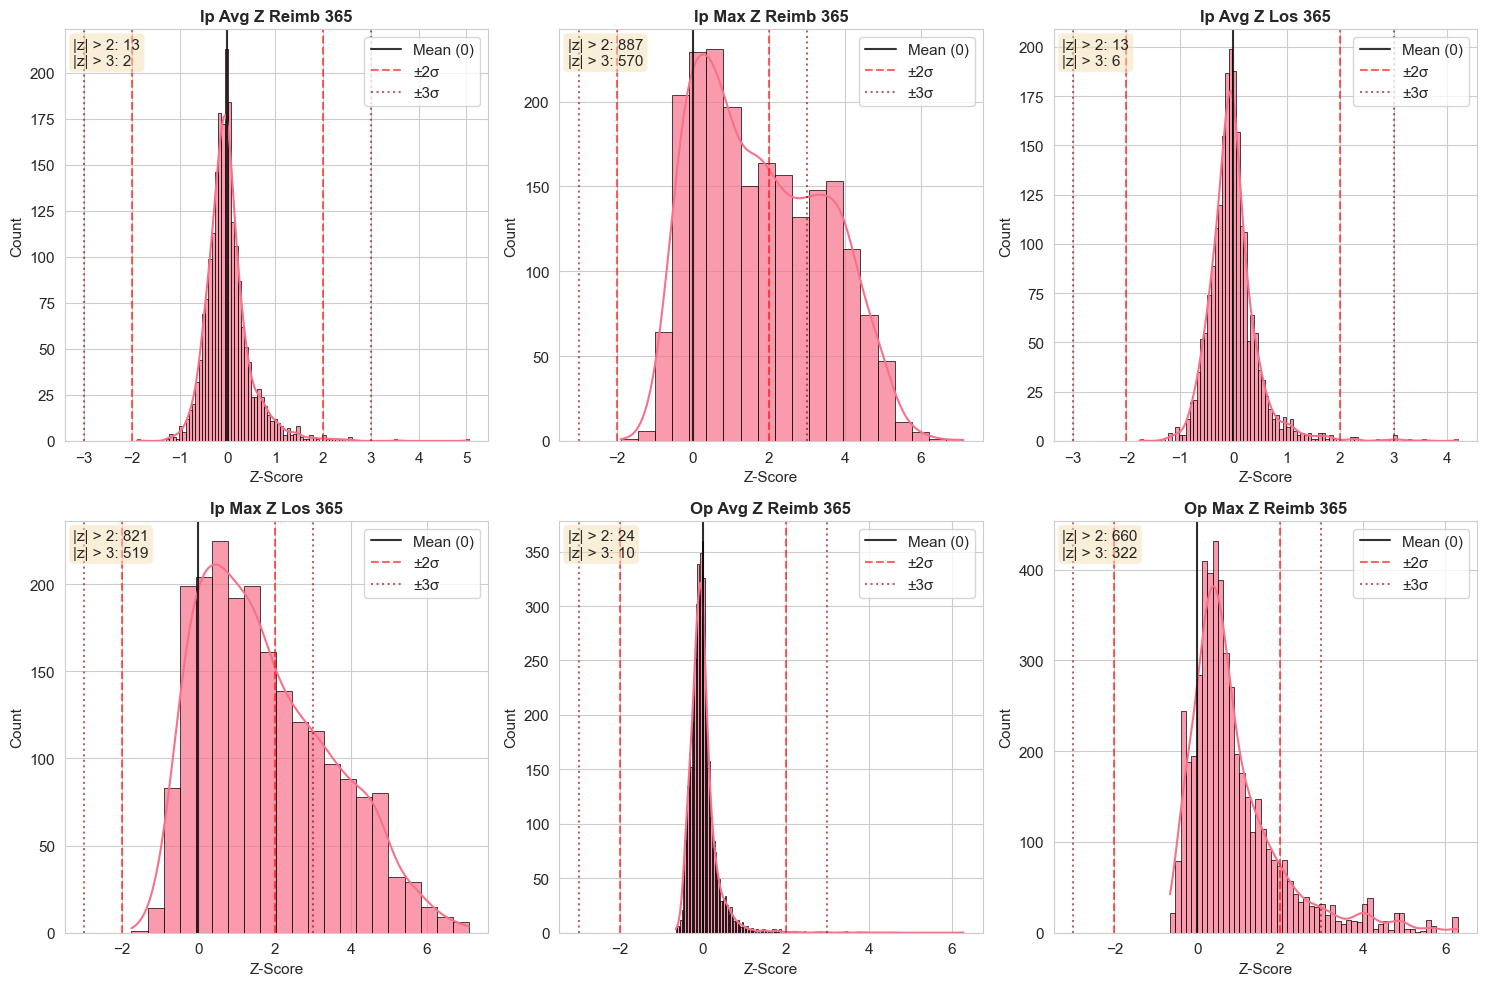

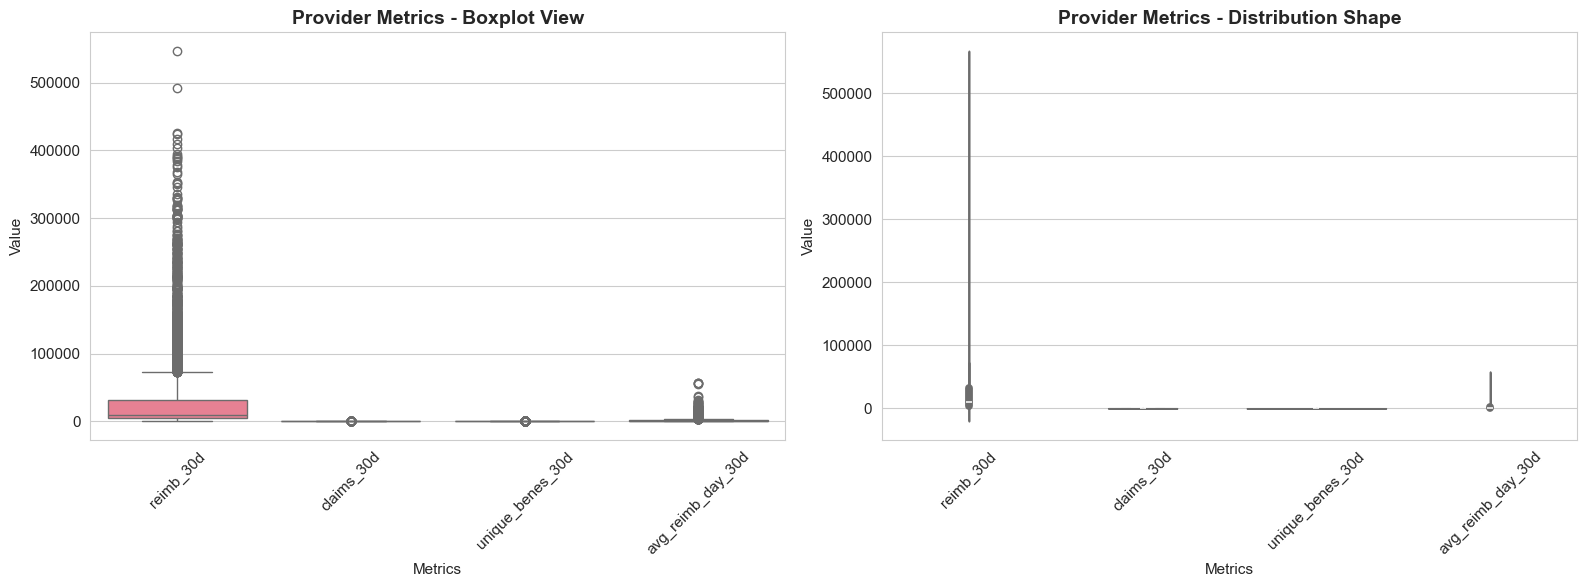

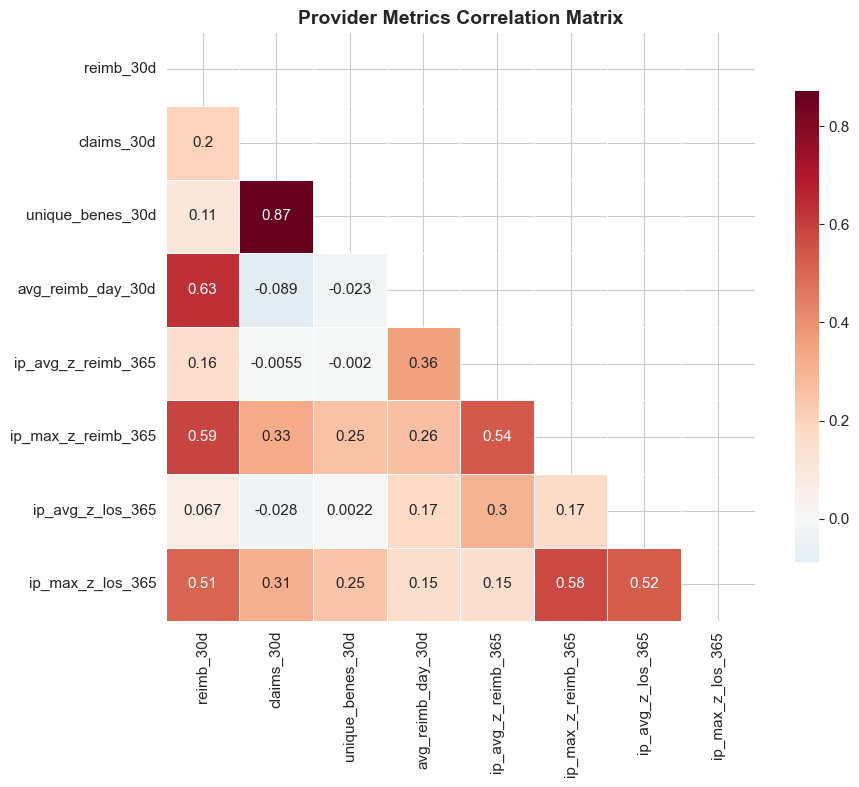

In [14]:
# 1. Recent activity metrics
activity_cols = ["reimb_30d", "claims_30d", "unique_benes_30d", "dx_distinct_30d", "avg_reimb_day_30d", "deductible_share_30d"]
available_cols = [col for col in activity_cols if col in providers.columns]

if available_cols:
    n_cols = 3
    n_rows = (len(available_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, col in enumerate(available_cols):
        ax = axes[i]
        # Use seaborn histogram with KDE overlay
        sns.histplot(data=providers, x=col, kde=True, ax=ax, bins=fd_bins(providers[col]))
        ax.set_title(f"{col.replace('_', ' ').title()} Distribution", fontsize=12, fontweight='bold')
        ax.set_xlabel(col.replace('_', ' ').title())
        ax.set_ylabel("Count")
        
        # Add summary statistics as text
        mean_val = providers[col].mean()
        median_val = providers[col].median()
        ax.axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:,.2f}')
        ax.axvline(median_val, color='orange', linestyle='--', alpha=0.7, label=f'Median: {median_val:,.2f}')
        ax.legend()
    
    # Hide extra subplots
    for i in range(len(available_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# 2. Z-scores with better styling and layout
z_score_cols = ["ip_avg_z_reimb_365", "ip_max_z_reimb_365", "ip_avg_z_los_365", "ip_max_z_los_365",
                "op_avg_z_reimb_365", "op_max_z_reimb_365"]
available_z_cols = [col for col in z_score_cols if col in providers.columns]

if available_z_cols:
    n_cols = 3
    n_rows = (len(available_z_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, col in enumerate(available_z_cols):
        ax = axes[i]
        # Enhanced histogram for z-scores
        sns.histplot(data=providers, x=col, kde=True, ax=ax, bins=fd_bins(providers[col]),
                    alpha=0.7, edgecolor='black', linewidth=0.5)
        
        # Add reference lines for z-score interpretation
        ax.axvline(0, color='black', linestyle='-', alpha=0.8, label='Mean (0)')
        ax.axvline(-2, color='red', linestyle='--', alpha=0.6, label='±2σ')
        ax.axvline(2, color='red', linestyle='--', alpha=0.6)
        ax.axvline(-3, color='darkred', linestyle=':', alpha=0.6, label='±3σ')
        ax.axvline(3, color='darkred', linestyle=':', alpha=0.6)
        
        ax.set_title(f"{col.replace('_', ' ').title()}", fontsize=12, fontweight='bold')
        ax.set_xlabel("Z-Score")
        ax.set_ylabel("Count")
        ax.legend()
        
        # Add text with outlier counts
        outliers_2sigma = ((providers[col] < -2) | (providers[col] > 2)).sum()
        outliers_3sigma = ((providers[col] < -3) | (providers[col] > 3)).sum()
        ax.text(0.02, 0.98, f'|z| > 2: {outliers_2sigma}\n|z| > 3: {outliers_3sigma}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Hide extra subplots
    for i in range(len(available_z_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# 3. Enhanced boxplots with violin plots for better distribution view
cols_bp = [c for c in ["reimb_30d", "claims_30d", "unique_benes_30d", "avg_reimb_day_30d"] 
           if c in providers.columns]

if cols_bp:
    # Create a melted dataframe for seaborn
    provider_melted = providers[cols_bp].melt(var_name='Metric', value_name='Value')
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Boxplot
    sns.boxplot(data=provider_melted, x='Metric', y='Value', ax=ax1)
    ax1.set_title("Provider Metrics - Boxplot View", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Metrics")
    ax1.set_ylabel("Value")
    ax1.tick_params(axis='x', rotation=45)
    
    # Violin plot for distribution shape
    sns.violinplot(data=provider_melted, x='Metric', y='Value', ax=ax2)
    ax2.set_title("Provider Metrics - Distribution Shape", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Metrics")
    ax2.set_ylabel("Value")
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# 4. Correlation heatmap for provider metrics
if len(cols_bp) > 1:
    plt.figure(figsize=(10, 8))
    correlation_matrix = providers[cols_bp + available_z_cols[:4]].corr()
    
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title("Provider Metrics Correlation Matrix", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

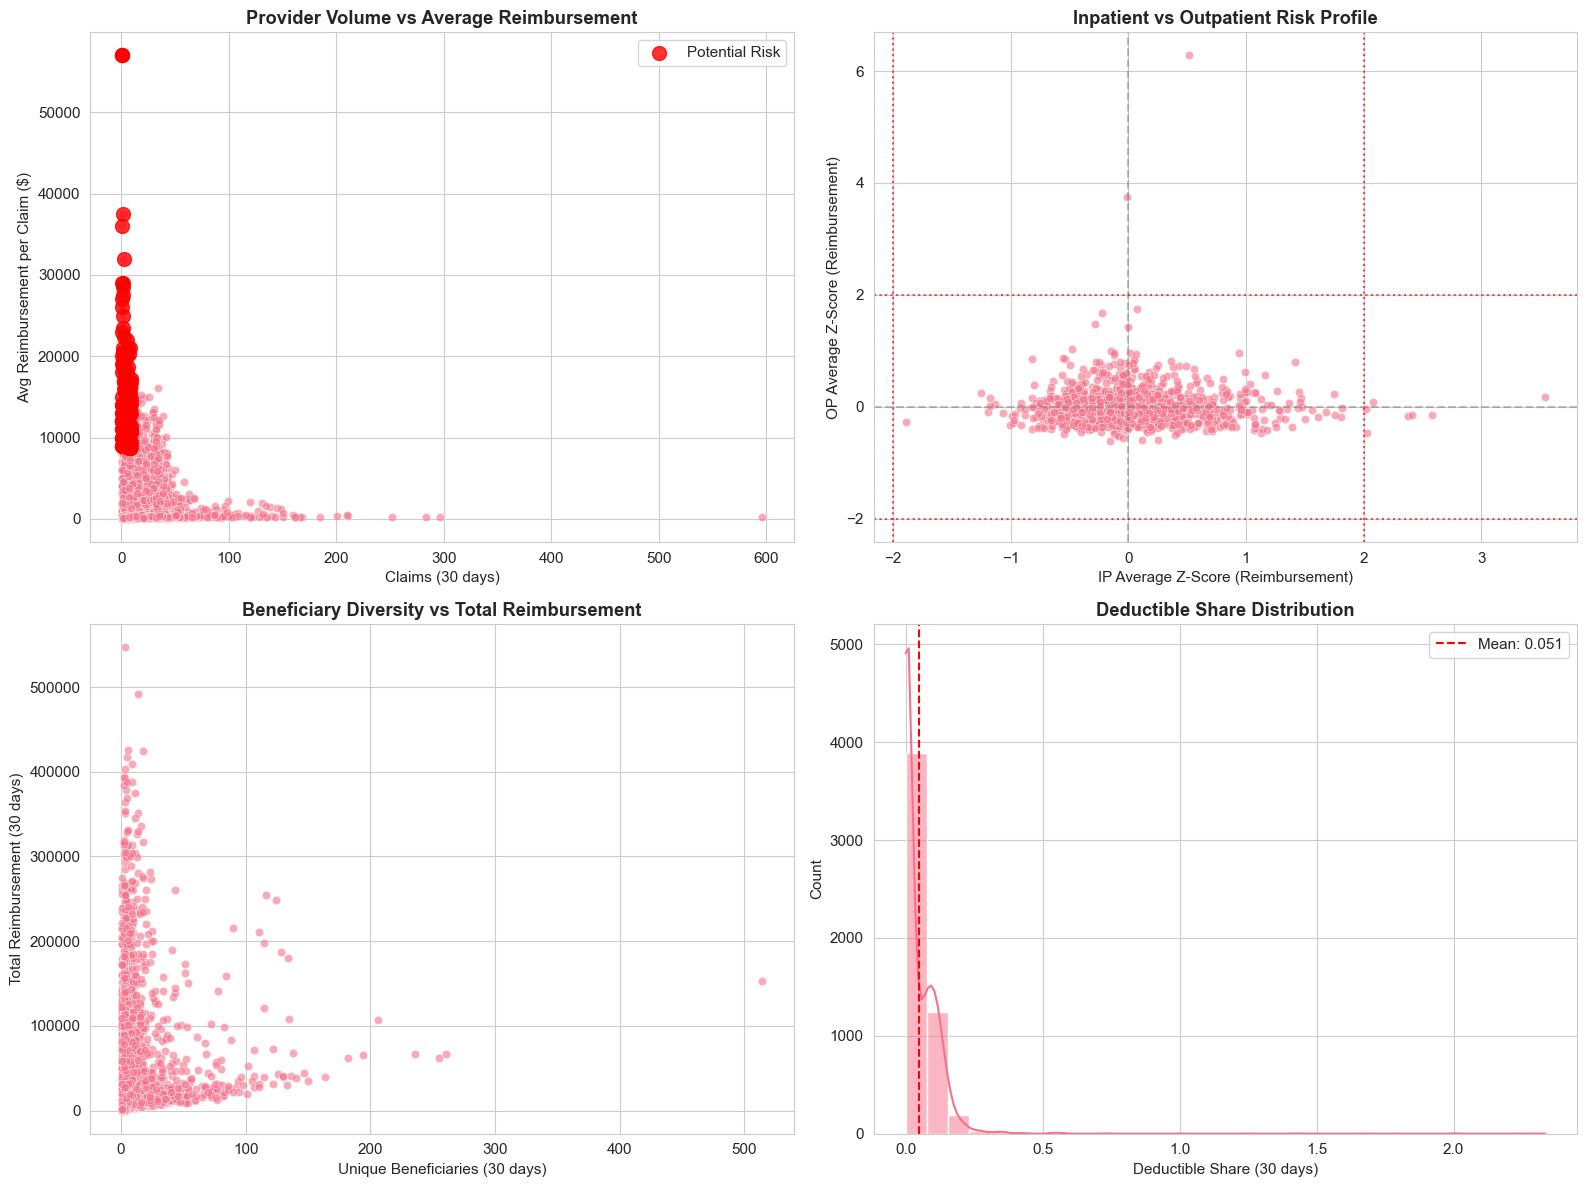


PROVIDER RISK INDICATORS
High IP Z-Score (>2): 13 providers (0.2%)
High OP Z-Score (>2): 24 providers (0.4%)
High Avg Reimbursement (>$8,667+): 269 providers (5.0%)
Low Deductible Share (<0.000): 0 providers (0.0%)

Total providers analyzed: 5410


In [15]:
# 1. Provider risk profiling using multiple metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# High-value providers analysis
if 'reimb_30d' in providers.columns and 'claims_30d' in providers.columns:
    # Calculate average reimbursement per claim
    providers['avg_reimb_per_claim'] = providers['reimb_30d'] / providers['claims_30d']
    
    # Scatter plot: volume vs average reimbursement
    sns.scatterplot(data=providers, x='claims_30d', y='avg_reimb_per_claim', 
                    alpha=0.6, ax=axes[0,0])
    axes[0,0].set_title("Provider Volume vs Average Reimbursement", fontweight='bold')
    axes[0,0].set_xlabel("Claims (30 days)")
    axes[0,0].set_ylabel("Avg Reimbursement per Claim ($)")
    
    # Identify potential outliers (high reimbursement, low volume)
    high_reimb_threshold = providers['avg_reimb_per_claim'].quantile(0.95)
    low_volume_threshold = providers['claims_30d'].quantile(0.25)
    
    outlier_mask = ((providers['avg_reimb_per_claim'] > high_reimb_threshold) & 
                    (providers['claims_30d'] < low_volume_threshold))
    
    if outlier_mask.any():
        axes[0,0].scatter(providers.loc[outlier_mask, 'claims_30d'],
                         providers.loc[outlier_mask, 'avg_reimb_per_claim'],
                         color='red', s=100, alpha=0.8, label='Potential Risk')
        axes[0,0].legend()

# 2. Z-score risk matrix
z_cols_available = [col for col in ['ip_avg_z_reimb_365', 'op_avg_z_reimb_365'] 
                   if col in providers.columns]

if len(z_cols_available) >= 2:
    sns.scatterplot(data=providers, x=z_cols_available[0], y=z_cols_available[1], 
                    alpha=0.6, ax=axes[0,1])
    axes[0,1].set_title("Inpatient vs Outpatient Risk Profile", fontweight='bold')
    axes[0,1].set_xlabel("IP Average Z-Score (Reimbursement)")
    axes[0,1].set_ylabel("OP Average Z-Score (Reimbursement)")
    
    # Add quadrant lines
    axes[0,1].axhline(0, color='gray', linestyle='--', alpha=0.5)
    axes[0,1].axvline(0, color='gray', linestyle='--', alpha=0.5)
    axes[0,1].axhline(2, color='red', linestyle=':', alpha=0.7)
    axes[0,1].axvline(2, color='red', linestyle=':', alpha=0.7)
    axes[0,1].axhline(-2, color='red', linestyle=':', alpha=0.7)
    axes[0,1].axvline(-2, color='red', linestyle=':', alpha=0.7)

# 3. Beneficiary diversity vs reimbursement
if 'unique_benes_30d' in providers.columns and 'reimb_30d' in providers.columns:
    sns.scatterplot(data=providers, x='unique_benes_30d', y='reimb_30d', 
                    alpha=0.6, ax=axes[1,0])
    axes[1,0].set_title("Beneficiary Diversity vs Total Reimbursement", fontweight='bold')
    axes[1,0].set_xlabel("Unique Beneficiaries (30 days)")
    axes[1,0].set_ylabel("Total Reimbursement (30 days)")

# 4. Deductible patterns
if 'deductible_share_30d' in providers.columns:
    sns.histplot(data=providers, x='deductible_share_30d', kde=True, 
                 bins=30, ax=axes[1,1])
    axes[1,1].set_title("Deductible Share Distribution", fontweight='bold')
    axes[1,1].set_xlabel("Deductible Share (30 days)")
    axes[1,1].set_ylabel("Count")
    
    # Add reference lines
    mean_deduct = providers['deductible_share_30d'].mean()
    axes[1,1].axvline(mean_deduct, color='red', linestyle='--', 
                     label=f'Mean: {mean_deduct:.3f}')
    axes[1,1].legend()

plt.tight_layout()
plt.show()

# 5. Risk scoring visualization
print("\n" + "="*70)
print("PROVIDER RISK INDICATORS")
print("="*70)

# Calculate risk indicators
risk_indicators = {}

if 'ip_avg_z_reimb_365' in providers.columns:
    risk_indicators['High IP Z-Score (>2)'] = (providers['ip_avg_z_reimb_365'] > 2).sum()

if 'op_avg_z_reimb_365' in providers.columns:
    risk_indicators['High OP Z-Score (>2)'] = (providers['op_avg_z_reimb_365'] > 2).sum()

if 'avg_reimb_per_claim' in providers.columns:
    high_avg_reimb = providers['avg_reimb_per_claim'].quantile(0.95)
    risk_indicators[f'High Avg Reimbursement (>${high_avg_reimb:,.0f}+)'] = (
        providers['avg_reimb_per_claim'] > high_avg_reimb).sum()

if 'deductible_share_30d' in providers.columns:
    low_deductible = providers['deductible_share_30d'].quantile(0.05)
    risk_indicators[f'Low Deductible Share (<{low_deductible:.3f})'] = (
        providers['deductible_share_30d'] < low_deductible).sum()

for indicator, count in risk_indicators.items():
    print(f"{indicator}: {count} providers ({count/len(providers)*100:.1f}%)")

print(f"\nTotal providers analyzed: {len(providers)}")
print("="*70)

### 3.2 - Correlate features: check for multicollinearity, redundant features

##### A - Select numeric features (claims + providers)

In [16]:
# choose numeric-only columns (drops ids/text)
num_claims = claims.select_dtypes(include=[np.number]).copy()
num_prov = providers.select_dtypes(include=[np.number]).copy()

num_claims.shape, num_prov.shape

((558211, 5), (5410, 14))

##### B - Correlation matrices (Pearson & Spearman) + heatmap

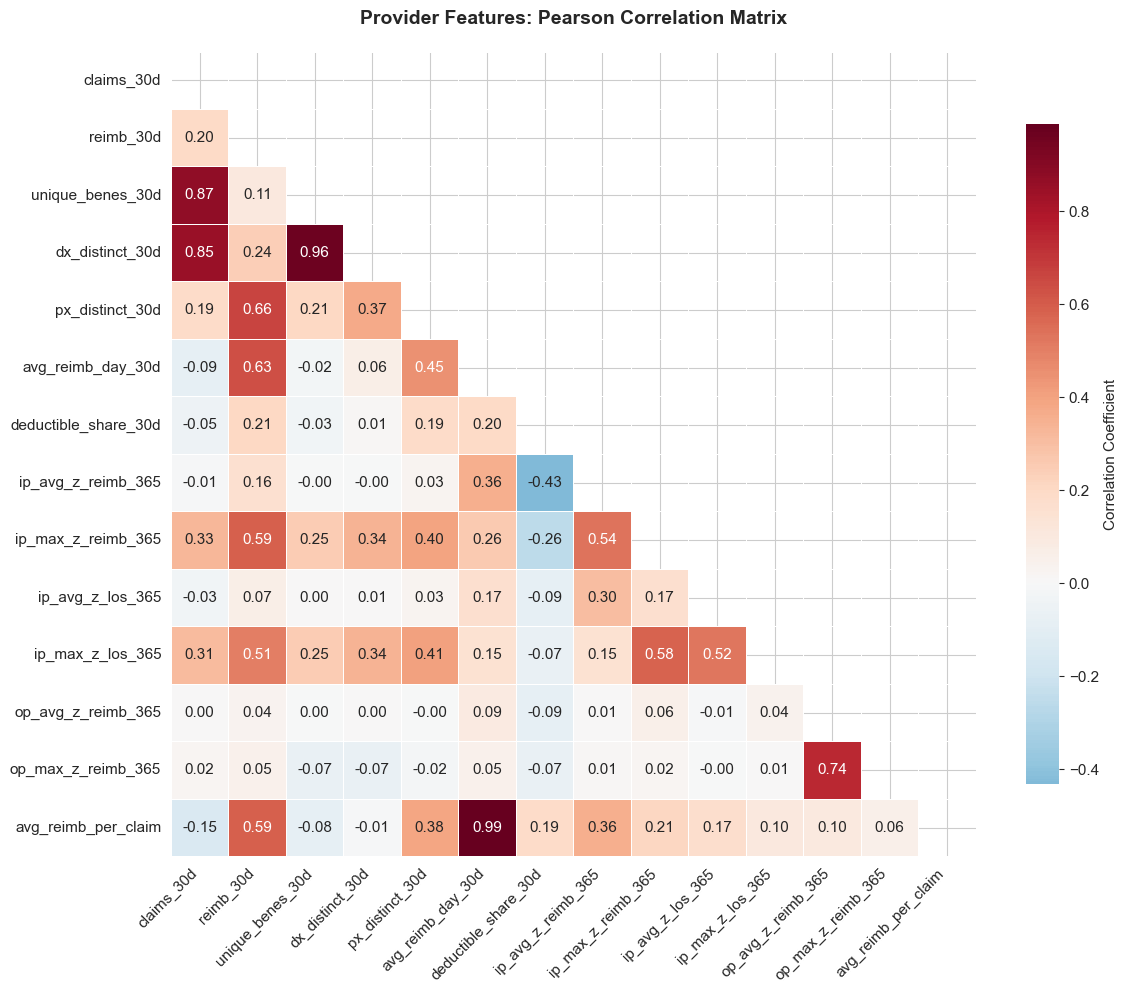

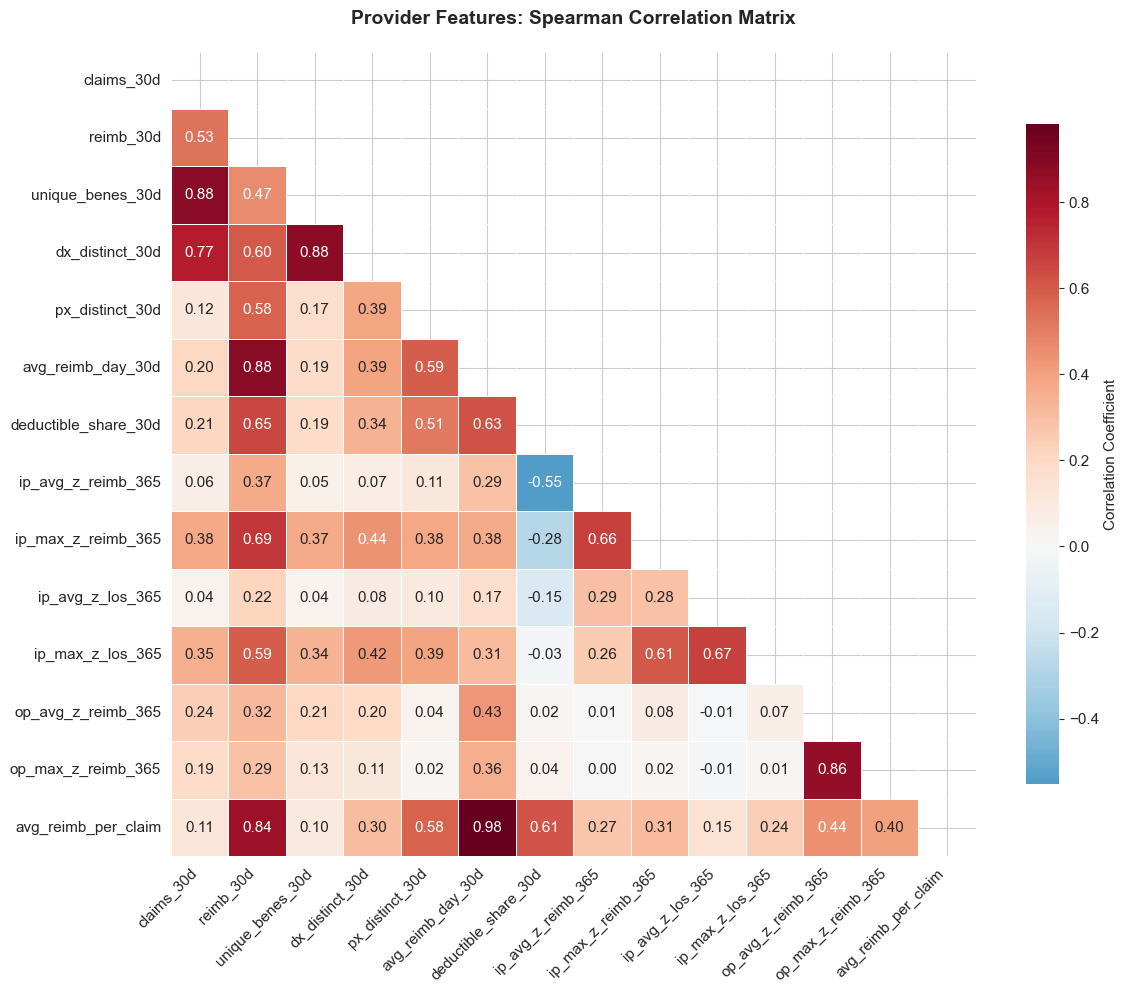

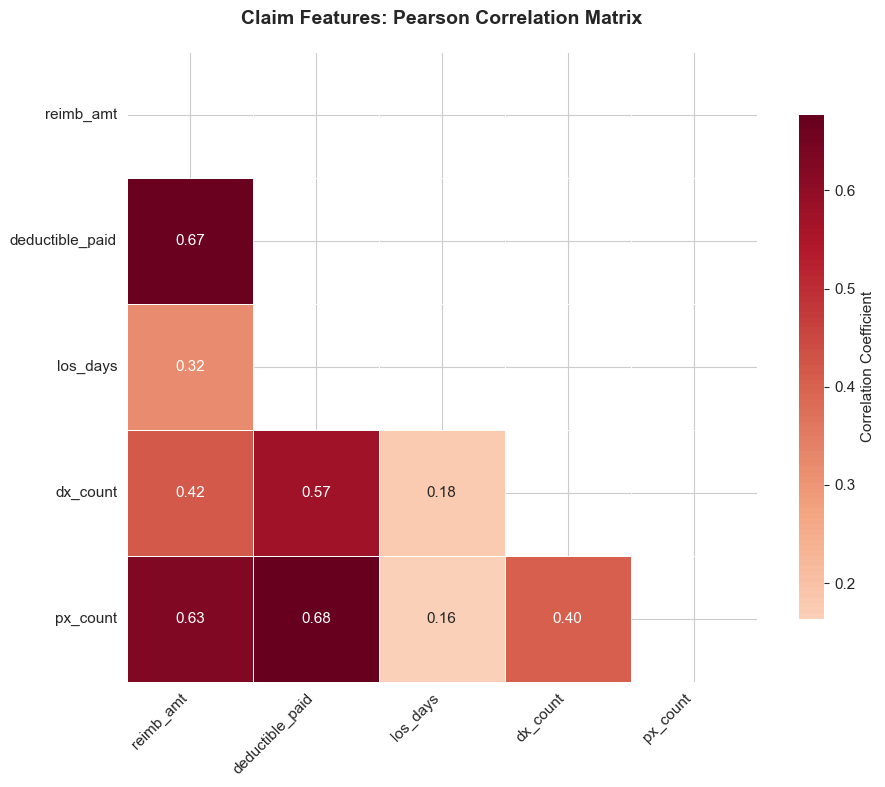

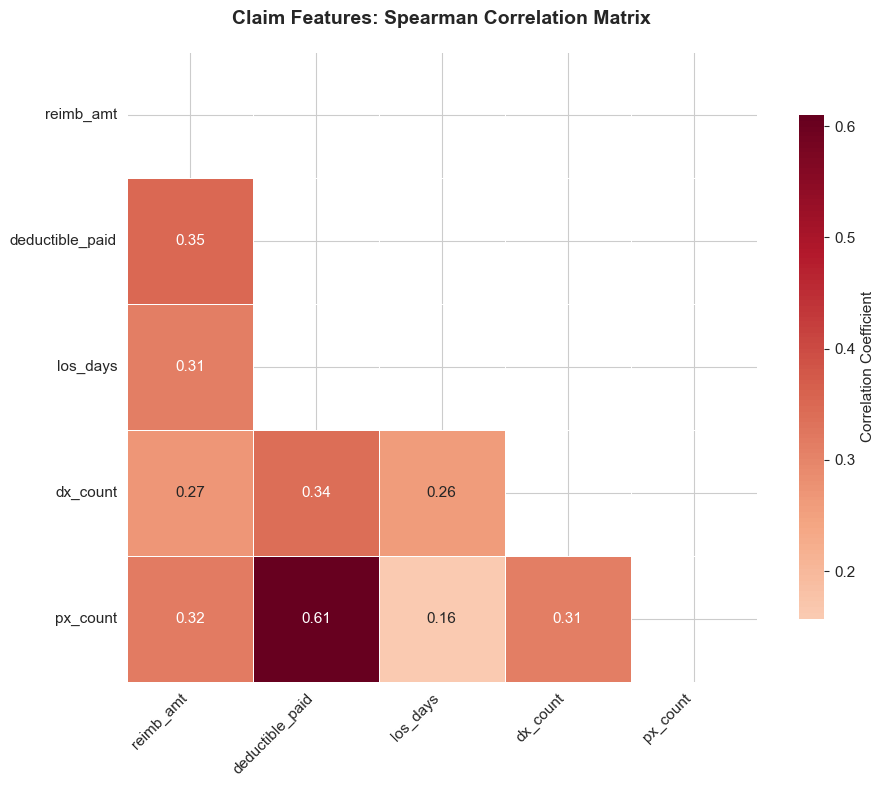


HIGH CORRELATION PAIRS - PROVIDER FEATURES (Pearson)
avg_reimb_day_30d              <-> avg_reimb_per_claim            :  0.987
unique_benes_30d               <-> dx_distinct_30d                :  0.962
claims_30d                     <-> unique_benes_30d               :  0.871
claims_30d                     <-> dx_distinct_30d                :  0.854

HIGH CORRELATION PAIRS - CLAIM FEATURES (Pearson)
No feature pairs with |correlation| > 0.8 found


c:\Users\zayed\anaconda3\envs\KNCVU\Lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


<Figure size 1200x1000 with 0 Axes>

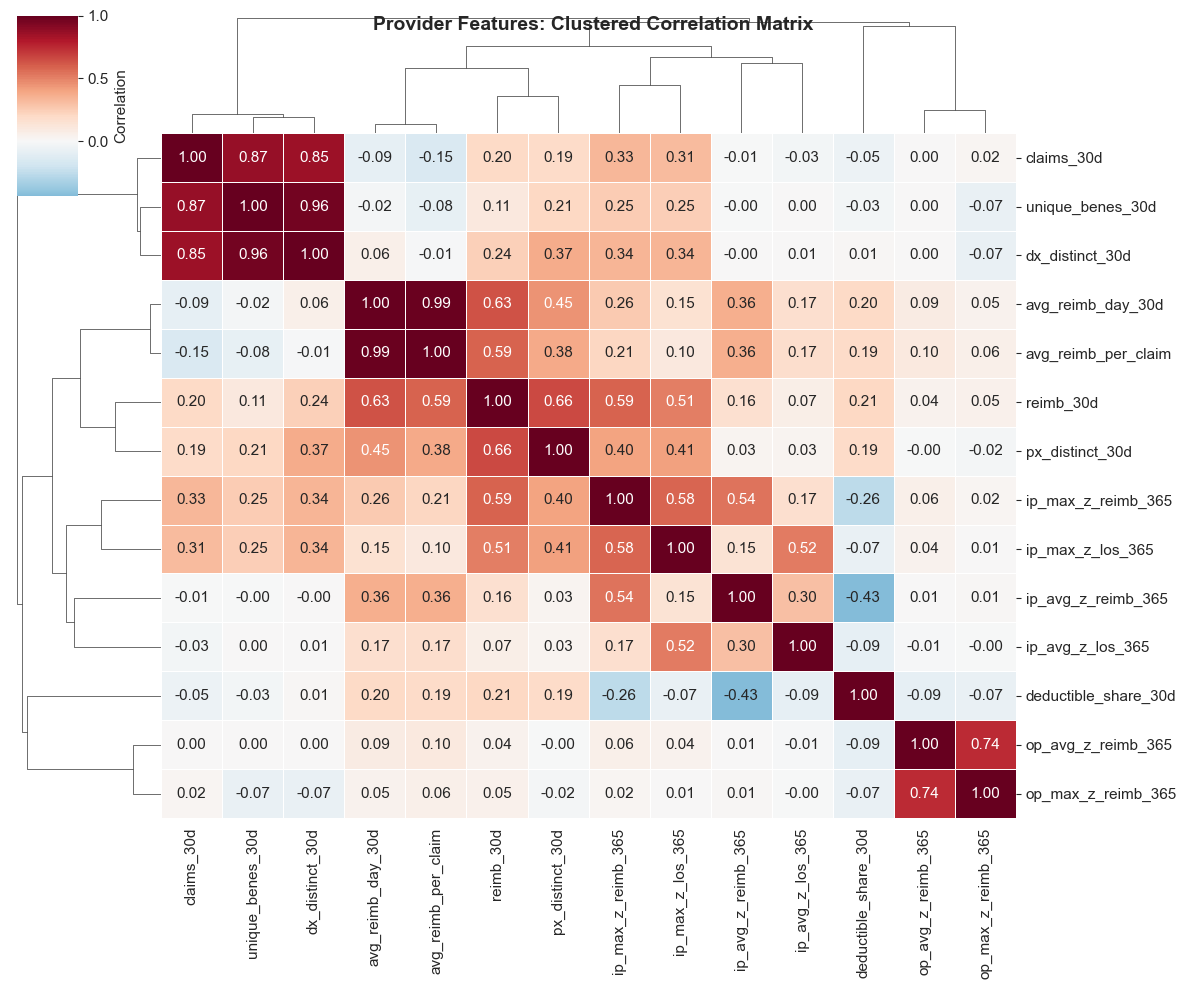

In [17]:
# 1) Pearson (linear)
corr_claims_pearson = num_claims.corr(method='pearson')
corr_prov_pearson = num_prov.corr(method='pearson')

# 2) Spearman (rank/monotonic; more robust to skew)
corr_claims_spearman = num_claims.corr(method='spearman')
corr_prov_spearman = num_prov.corr(method='spearman')

# Provider-level: Pearson correlation
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_prov_pearson, dtype=bool))
sns.heatmap(corr_prov_pearson, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"})
plt.title("Provider Features: Pearson Correlation Matrix", fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Provider-level: Spearman correlation
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_prov_spearman, dtype=bool))
sns.heatmap(corr_prov_spearman, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"})
plt.title("Provider Features: Spearman Correlation Matrix", fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Claims-level: Pearson correlation
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_claims_pearson, dtype=bool))
sns.heatmap(corr_claims_pearson, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"})
plt.title("Claim Features: Pearson Correlation Matrix", fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Claims-level: Spearman correlation
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_claims_spearman, dtype=bool))
sns.heatmap(corr_claims_spearman, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"})
plt.title("Claim Features: Spearman Correlation Matrix", fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 4) Identify highly correlated features (potential multicollinearity)
print("\n" + "="*70)
print("HIGH CORRELATION PAIRS - PROVIDER FEATURES (Pearson)")
print("="*70)

# Find pairs with |correlation| > 0.8 (excluding diagonal)
high_corr_pairs = []
for i in range(len(corr_prov_pearson.columns)):
    for j in range(i+1, len(corr_prov_pearson.columns)):
        corr_val = corr_prov_pearson.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((
                corr_prov_pearson.columns[i],
                corr_prov_pearson.columns[j],
                corr_val
            ))

if high_corr_pairs:
    for feat1, feat2, corr_val in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"{feat1:30s} <-> {feat2:30s} : {corr_val:6.3f}")
else:
    print("No feature pairs with |correlation| > 0.8 found")

print("\n" + "="*70)
print("HIGH CORRELATION PAIRS - CLAIM FEATURES (Pearson)")
print("="*70)

high_corr_pairs_claims = []
for i in range(len(corr_claims_pearson.columns)):
    for j in range(i+1, len(corr_claims_pearson.columns)):
        corr_val = corr_claims_pearson.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs_claims.append((
                corr_claims_pearson.columns[i],
                corr_claims_pearson.columns[j],
                corr_val
            ))

if high_corr_pairs_claims:
    for feat1, feat2, corr_val in sorted(high_corr_pairs_claims, key=lambda x: abs(x[2]), reverse=True):
        print(f"{feat1:30s} <-> {feat2:30s} : {corr_val:6.3f}")
else:
    print("No feature pairs with |correlation| > 0.8 found")

print("="*70)

# 5) Clustermap for hierarchical clustering of correlated features (Provider)
if len(corr_prov_pearson.columns) > 2:
    plt.figure(figsize=(12, 10))
    sns.clustermap(corr_prov_pearson, annot=True, fmt='.2f', 
                   cmap='RdBu_r', center=0, square=True, linewidths=0.5,
                   cbar_kws={"shrink": 0.8, "label": "Correlation"},
                   dendrogram_ratio=0.15, figsize=(12, 10))
    plt.suptitle("Provider Features: Clustered Correlation Matrix", 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.show()

#### C) Auto-flag highly correlated pairs (redundancy screen)

In [18]:
def corr_pairs_to_drop(corr, threshold=0.9):
    # keep only upper triangle (exclude diag)
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    high = (corr.where(mask).abs() >= threshold)
    pairs = [(corr.index[i], corr.columns[j], corr.values[i, j])
             for i in range(corr.shape[0]) for j in range(corr.shape[1])
             if mask[i, j] and abs(corr.values[i, j]) >= threshold]
    return sorted(pairs, key=lambda x: -abs(x[2]))


high_pairs = corr_pairs_to_drop(corr_prov_pearson, threshold=0.9)
high_pairs[:10]  # review top redundant pairs

[('avg_reimb_day_30d', 'avg_reimb_per_claim', np.float64(0.9869572295302257)),
 ('unique_benes_30d', 'dx_distinct_30d', np.float64(0.9624659480201365))]

#### D) VIF (Variance Inflation Factor) to detect multicollinearity

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# choose a candidate set (drop obviously redundant ones first)
X = providers[[
    "claims_30d", "reimb_30d", "unique_benes_30d",
    "dx_distinct_30d", "avg_reimb_day_30d", "deductible_share_30d",
    "ip_avg_z_reimb_365", "ip_avg_z_los_365", "op_avg_z_reimb_365"
]].dropna()

# add constant if you later fit a model; VIF itself uses exog matrix
vif = pd.DataFrame({
    "feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
}).sort_values("VIF", ascending=False)
vif

,feature,VIF
3,dx_distinct_30d,31.89
2,unique_benes_30d,31.27
1,reimb_30d,12.95
4,avg_reimb_day_30d,11.19
0,claims_30d,10.77
5,deductible_share_30d,4.07
6,ip_avg_z_reimb_365,1.43
7,ip_avg_z_los_365,1.09
8,op_avg_z_reimb_365,1.02


##### E) Optional: p-values for pairwise correlations

In [20]:
from scipy.stats import pearsonr, spearmanr

def pair_corr_with_p(x, y, method="pearson"):
    x, y = pd.Series(x).dropna(), pd.Series(y).dropna()
    df = pd.concat([x, y], axis=1).dropna()
    if method == "pearson":
        r, p = pearsonr(df.iloc[:, 0], df.iloc[:, 1])
    else:
        r, p = spearmanr(df.iloc[:, 0], df.iloc[:, 1])
    return r, p

r, p = pair_corr_with_p(
    providers["reimb_30d"], providers["claims_30d"], method="spearman")
r, p

(np.float64(0.5339574617108254), np.float64(0.0))